In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from scipy import signal
from scipy import stats

In [2]:
# use fft to pull out frequency
def returnFFT(array, Fs):
    from scipy.fftpack import fft
    
    meanx = np.mean(array)
    fftr = fft(array - meanx)
        
    Nsamples = len(r) # number of points
    Nf = Nsamples # max Nyquist frequency is Nf/2
    
    TT = 1/Fs # resolution of frequency

    xf = np.linspace(0.0, 1.0/(2.0*TT), round(Nf/(2)))
    
    return(xf, fftr)

In [4]:
visitnum = ['FirstVisit/', 'LaterVisit/']
for visit in visitnum[-1:]:
    path = os.path.join('../dataFolders/PaperPipelineOutput/RadiusAndAngle_v2/', visit)
    Allpath = glob.glob(path + 'c*.csv')
    
    guidepath = os.path.join("../dataFolders/PaperPipelineOutput/FilteredTracks_v2/", visit)
    guide = pd.read_csv(guidepath + "AllVideoNames.csv")
    # print(guide.head())
    filesToRead = guide[guide.AutomatatedTracking != "TRUE"]
    
    outpathfig = os.path.join('../dataFolders/PaperPipelineOutput/Figures/v2/Dynamics-Rythmicity/',visit)

In [5]:
n = []
peaks = []
freq = []
for path in Allpath:
    name = os.path.basename(path)[:-19]
#     name =  'c-1_m19'
#     path = [p for p in Allpath if name in p][0]
    if np.any(filesToRead.names.str.contains(name)):
        continue
#     path = [data for data in Allpath if name in data]
    dataExamples = pd.read_csv(path)
    
    r = dataExamples.radial_distance_normalized.values
    r[r > 2.5] = np.nan
    
    # get the number of peaks
    ind, _ = signal.find_peaks(r, prominence=(0.5, ) )
    plt.plot(r)
    plt.plot(ind, r[ind], 'o')
    plt.savefig(outpathfig + name + '_peaks.pdf')
    plt.close()
    
    
    # testing the Welch method
    s = np.split(r, np.where(np.isnan(r))[0]+1)
    nanFreeSeg = max(s, key = len)
    f, Pxx = signal.welch(x= nanFreeSeg, 
                          fs=100.0, 
                          window='hanning',
                          nperseg = round(len(r)/5),
                          return_onesided=True, scaling='density')
    plt.plot(f, Pxx)
    plt.savefig(outpathfig + name + '_welchFFT.pdf')
    plt.close()
    
    max_f = f[np.argmax(Pxx)]

#     print('max freq for %s is: %.2f Hz' % (name, f[np.argmax(Pxx)]))
        
    n.append(name)
    peaks.append(len(ind))
    freq.append(max_f)

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [6]:
# save this data as a csv
SweepDynamics = pd.DataFrame([n, peaks, freq]).T
SweepDynamics.columns = ['names', 'numPeaks', 'freq']
SweepDynamics.to_csv(path + 'SweepDynamics.csv')

In [7]:
# plot the results
SweepDynamics[['flower', 'mothname']] = SweepDynamics.names.str.split(pat = '_', n = 2, expand = True)
SweepDynamics["numPeaks"] = pd.to_numeric(SweepDynamics["numPeaks"])
SweepDynamics["freq"] = pd.to_numeric(SweepDynamics["freq"])
SweepDynamics.head()
SweepDynamics.to_csv(path + 'SweepDynamics.csv')

(-5, 40)

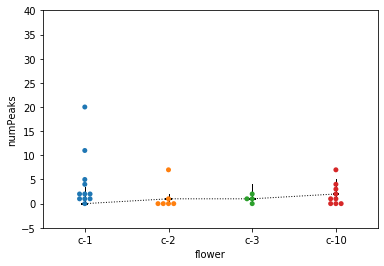

In [15]:
import seaborn as sns

f = sns.swarmplot(x = 'flower', y = 'numPeaks',
                  data = SweepDynamics)
sns.pointplot(x="flower", y="numPeaks", estimator = np.median, data=SweepDynamics, 
#               ci = 'sd',
              markers = '_',
              linestyles = 'dotted',
              color = 'k',
             order = ["c-1" ,"c-2", "c-3", "c-10"])

plt.setp(f.lines,linewidth=1) 
ax = f.axes
ax.set_ylim(-5,40)

In [9]:
m = SweepDynamics.groupby('flower')['numPeaks'].apply(np.median)
m

flower
c-1     0.0
c-10    2.0
c-2     1.0
c-3     1.0
Name: numPeaks, dtype: float64

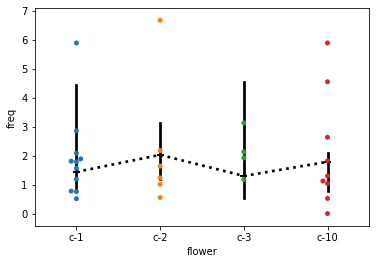

In [10]:
sns.swarmplot(x = 'flower', y = 'freq', data = SweepDynamics)
sns.pointplot(x="flower", y="freq", estimator = np.median, data=SweepDynamics, 
#               ci = 'sd',
              markers = '_',
              linestyles = 'dotted',
              color = 'k',
             order = ["c-1" ,"c-2", "c-3", "c-10"])

In [11]:
f = SweepDynamics.groupby('flower')['freq'].apply(np.median)
f

flower
c-1     1.436956
c-10    1.785714
c-2     2.025368
c-3     1.298701
Name: freq, dtype: float64

In [12]:
for name, grp in SweepDynamics.groupby('flower'):
    f,p = stats.normaltest(grp['numPeaks'])
    print('%s has %.2f stats and %.15f p value' %(name,f,p))
    if p < 0.5:
        print('%s is not normally distributed' %name)
    else:
        print('%s is normally distributed' %name)

ValueError: skewtest is not valid with less than 8 samples; 6 samples were given.

In [13]:
c1 = SweepDynamics.loc[SweepDynamics.flower == 'c-1', 'numPeaks'].values
c2 = SweepDynamics.loc[SweepDynamics.flower == 'c-2', 'numPeaks'].values
c3 = SweepDynamics.loc[SweepDynamics.flower == 'c-3', 'numPeaks'].values
c10 = SweepDynamics.loc[SweepDynamics.flower == 'c-10', 'numPeaks'].values
stats.kruskal(list(c1), list(c2), list(c3), list(c10))

KruskalResult(statistic=5.113671264057764, pvalue=0.1636603129133936)

In [14]:
for name, grp in SweepDynamics.groupby('flower'):
    f,p = stats.normaltest(grp['freq'])
    print('%s has %.2f stats and %.15f p value' %(name,f,p))
    if p < 0.5:
        print('%s is not normally distributed' %name)
    else:
        print('%s is normally distributed' %name)

c-1 has 3.98 stats and 0.136845431749035 p value
c-1 is not normally distributed
c-10 has 2.20 stats and 0.333277248555266 p value
c-10 is not normally distributed
c-2 has 18.15 stats and 0.000114216761620 p value
c-2 is not normally distributed
c-3 has 2.70 stats and 0.258709026727708 p value
c-3 is not normally distributed


In [14]:
c1 = SweepDynamics.loc[SweepDynamics.flower == 'c-1', 'freq'].values
c2 = SweepDynamics.loc[SweepDynamics.flower == 'c-2', 'freq'].values
c3 = SweepDynamics.loc[SweepDynamics.flower == 'c-3', 'freq'].values
c10 = SweepDynamics.loc[SweepDynamics.flower == 'c-10', 'freq'].values
stats.kruskal(list(c1), list(c2), list(c3), list(c10))

KruskalResult(statistic=0.9686090994502261, pvalue=0.8088470021956731)